# Comparing Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


plt.style.use("ggplot")

In [3]:
pred_names = [f.stem for f in Path("results").iterdir()]
pred_names

['qr_exp20', 'qr_exp21']

## Overall Model Comparison

Choose one or more of `pred_names` list above for comparison


In [4]:
use_preds = ["qr_preds"]

def read_files(names: list[str], folder: str) -> pd.DataFrame:
    res_list = []
    for name in names:
        res = pd.read_csv(f"{folder}/{name}.csv")
        res["pred_name"] = name
        res_list.append(res)
    return pd.concat(res_list, ignore_index=True)

res = read_files(use_preds, "results")

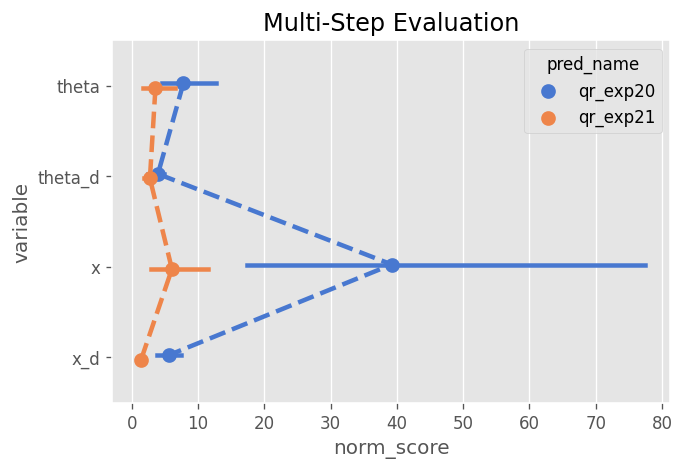

In [5]:
fig, ax = plt.subplots(dpi=120)
sns.pointplot(
    res.query("eval_mode == 'multi'"),
    x="norm_score",
    y="variable",
    hue="pred_name",
    orient="h",
    palette="muted",
    dodge=True,
    ax=ax,
    linestyles="--",
    errorbar="ci",
    order=["theta", "theta_d", "x", "x_d"]
)
ax.set_title("Multi-Step Evaluation")
plt.show()

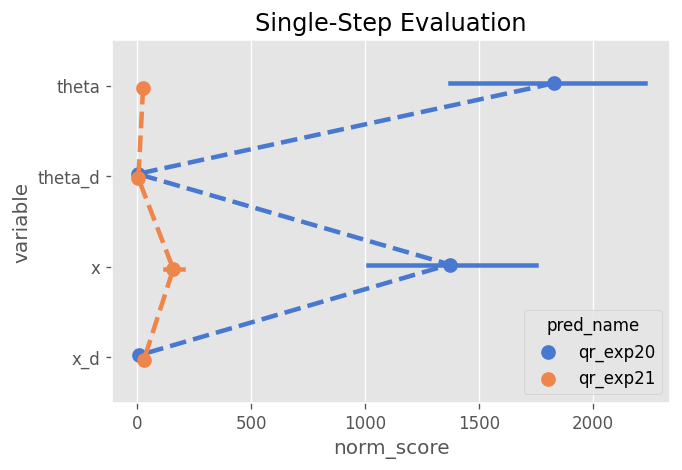

In [6]:
fig, ax = plt.subplots(dpi=120)
sns.pointplot(
    res.query("eval_mode == 'single'"),
    x="norm_score",
    y="variable",
    hue="pred_name",
    orient="h",
    palette="muted",
    dodge=True,
    ax=ax,
    linestyles="--",
    errorbar="ci",
    order=["theta", "theta_d", "x", "x_d"]
)
ax.set_title("Single-Step Evaluation")
plt.show()

## Comparison Breakdown

Only models whose evaluations are saved in the `full_results` folder can be evaluated here. These are shown in the output of the next cell.

In [7]:
full_pred_names = [f.stem for f in Path("full_results").iterdir()]
full_pred_names

['qr_exp20', 'qr_exp21']

In [8]:
use_full_preds = ["qr_preds"]

res_full = read_files(use_full_preds, "full_results")

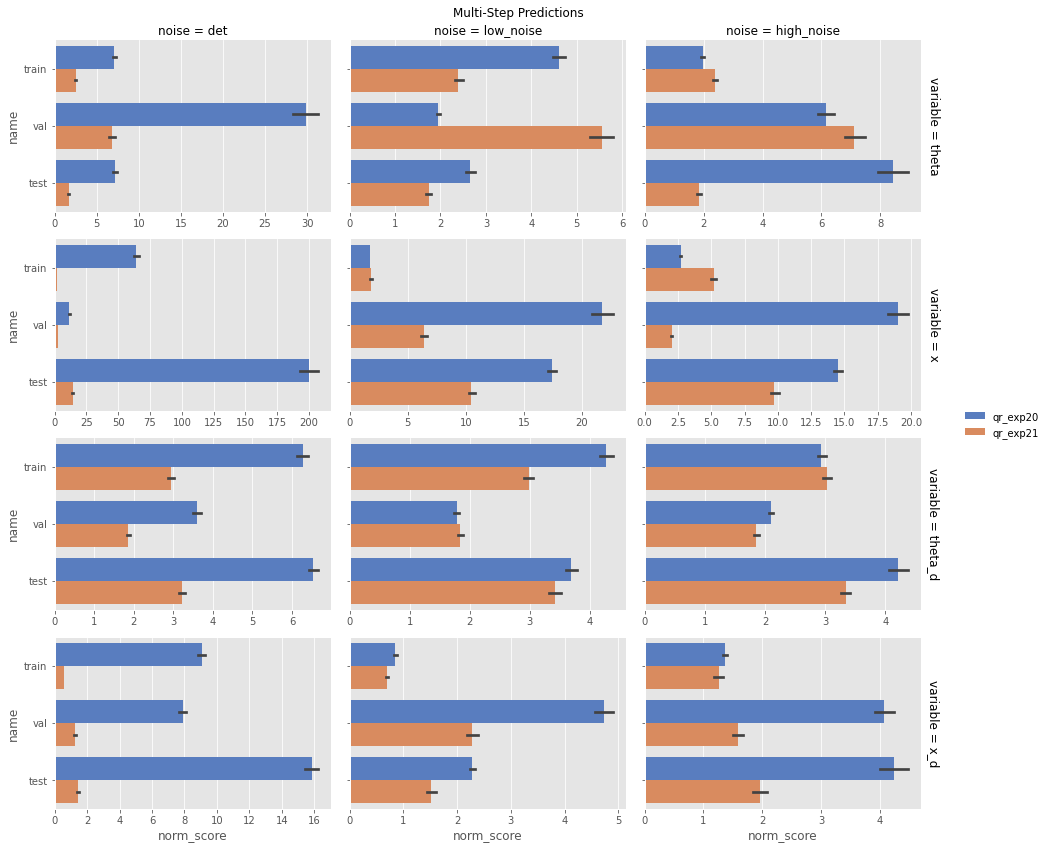

In [9]:

g = sns.FacetGrid(res_full.query("eval_mode == 'multi'"), row="variable", col="noise", aspect=1.5, margin_titles=True, sharex=False)
g.map_dataframe(sns.barplot, x="norm_score", y="name", hue="pred_name", orient="h", palette="muted")
g.fig.suptitle("Multi-Step Predictions")
g.fig.tight_layout()
g.add_legend()
plt.show()

## Visuals from a single Model

This section is for inspecting the predictions themselves, especially multi-step

In [20]:
pred_name = "qr_preds"
preds = pd.read_csv(f"predictions/{pred_name}.csv")
preds

,variable,t,lower_50,lower_80,lower_95,upper_50,upper_80,upper_95,actual,name,eval_mode,mean,noise
0,theta,0.00,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.300000,train,single,NaN,det
1,theta,0.01,0.010448,0.010448,0.010448,0.010448,0.010448,0.010448,0.310226,train,single,NaN,det
2,theta,0.02,0.010869,0.010869,0.010869,0.010869,0.010869,0.010869,0.320887,train,single,NaN,det
3,theta,0.03,0.011266,0.011266,0.011266,0.011266,0.011266,0.011266,0.331956,train,single,NaN,det
4,theta,0.04,0.011638,0.011638,0.011638,0.011638,0.011638,0.011638,0.343408,train,single,NaN,det
...,...,...,...,...,...,...,...,...,...,...,...,...,...
960067,x_d,199.96,-1.012852,-1.116196,-1.260340,-0.684338,-0.486616,-0.312631,-0.892315,test,multi,-0.744081,high_noise
960068,x_d,199.97,-1.022117,-1.122990,-1.272526,-0.686247,-0.491821,-0.331079,-0.854783,test,multi,-0.752632,high_noise
960069,x_d,199.98,-1.027902,-1.133409,-1.284334,-0.697015,-0.499939,-0.347719,-0.871656,test,multi,-0.759741,high_noise
960070,x_d,199.99,-1.032633,-1.134625,-1.287579,-0.702903,-0.506671,-0.363902,-0.824644,test,multi,-0.764028,high_noise


### Plot Single Trajectory

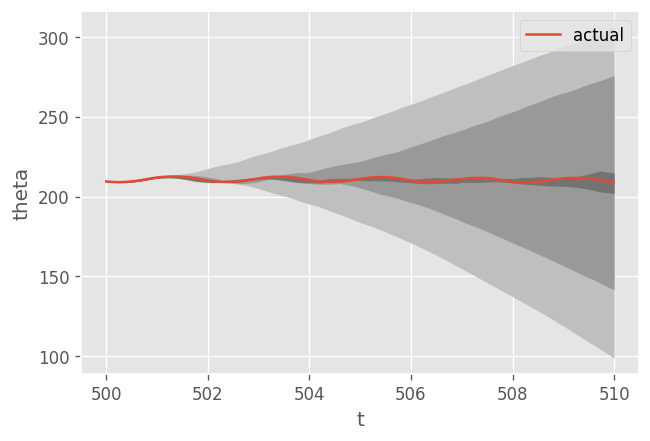

In [19]:

variable = "theta"
noise = "det"
name = "val"
eval_mode = "multi"
start_row = 0
nrows = 1000

# Helper Function
def qdf(df, vars):
    qstr = " & ".join(f"{var} == @{var}" for var in vars)
    return df.query(qstr)

# Filtered data
tmp = qdf(preds, ["name", "variable", "noise", "eval_mode"]).set_index("t").iloc[start_row:nrows]

# Plot
fig, ax = plt.subplots(dpi=120)
for i, lev in enumerate([95, 80, 50]):
    ax.fill_between(
        tmp.index,
        y1=tmp[f"lower_{lev}"],
        y2=tmp[f"upper_{lev}"],
        color=str(0.9 - 0.15 * (i + 1)),
        label="",
    )
tmp[["actual"]].plot(ax=ax)
ax.set_ylabel(variable)

plt.show()

### Plot all Trajectories from one Model

In [ ]:
# Nice plot
noise = "det"
name = "test"
eval_mode = "multi"
nrows = 2000  # seconds times 100

# Filtered data
df_filt = qdf(preds, ["noise", "name", "eval_mode"]).set_index("t")

name_lookup = {
    "det": "No Noise",
    "low_noise": "0.1 Gaussian Noise",
    "high_noise": "0.5 Gaussian Noise",
}
data_lookup = {
    "train": "Training Data",
    "valid": "Extending Trajectories",
    "test": "New Starting Position and Control Policy",
}
var_lookup = {
    "theta": r"$\theta$",
    "theta_d": r"$\dot{\theta}$",
    "x": r"$x$",
    "x_d": r"$\dot{x}$",
}
nice_name = ", ".join([pred_name, name_lookup[noise], data_lookup[name]])


# Plot
fig, axes = plt.subplots(nrows=4, figsize=(10, 12))
for var, ax in zip(var_lookup, axes):
    tmp = df_filt[df_filt.variable == var].iloc[:nrows]
    for i, lev in enumerate([95, 80, 50]):
        ax.fill_between(
            tmp.index,
            y1=tmp[f"lower_{lev}"],
            y2=tmp[f"upper_{lev}"],
            color=str(0.9 - 0.15 * (i + 1)),
            label="",
        )
    tmp[["actual"]].plot(ax=ax)
    ax.set_ylabel(var_lookup[var], rotation=0)
fig.suptitle(nice_name, fontsize=20)
fig.tight_layout()
plt.show()